In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from gradientOptimization.goptimization import optimizationMethods, optimizationFunctionFactory, VectorD

# Basic Analysis of State Dependent Gradient Descent

In this notebook we are going to experiment a little with the proposed state dependent gradient descent method. Let us start by looking at some of the funcitons. Here is the basic plotting routine.

In [2]:
from enum import Enum
from typing import Callable, List

class typeOfPlot(Enum):
    Surface = 0, 
    Contour = 1, 
    Both = 2

def box_surface_2d_tourch( init: List[float], 
                           end: List[float], 
                           step: float, 
                           functor: Callable[[VectorD],float], 
                           figsize = (16,8), 
                           cmap = cm.coolwarm, 
                           type_of_plot = typeOfPlot.Both,
                           extra_plotter = lambda : None  ):
    
    X = np.arange(init[0], end[0], step[0])
    Y = np.arange(init[1], end[1], step[1])
    X, Y = np.meshgrid(X, Y)
    Z = functor( torch.tensor([X,Y]) )
    
    if type_of_plot in [typeOfPlot.Both, typeOfPlot.Surface]:
        # Plot the surface.
        plt.figure(figsize = figsize )
        ax = plt.subplot('121', projection = '3d') if type_of_plot == typeOfPlot.Both else fig.gca(projection='3d')
        surf = ax.plot_surface(X, Y, Z.numpy(), cmap = cmap )
    
    if type_of_plot in [typeOfPlot.Both, typeOfPlot.Contour]:
        if type_of_plot == typeOfPlot.Both: ax = plt.subplot('122')
        else:
            fig = plt.figure(figsize = figsize )
            ax = fig.gca()
        CS = ax.contour(X, Y, Z, cmap = cmap )
        
    extra_plotter()
    plt.show()

To get the funcitons, we need to call the factory passing the function name as a string. This functor has an overwriten callable function, which means it can be called as if it was a simple funciton. As an example, we do the plot taking 200 samples per dimension, spaced unifromly on the box $[-1,1]\times[1,1]$ of the ackley funciton. We also plot the contour funciton next to it for better reference.

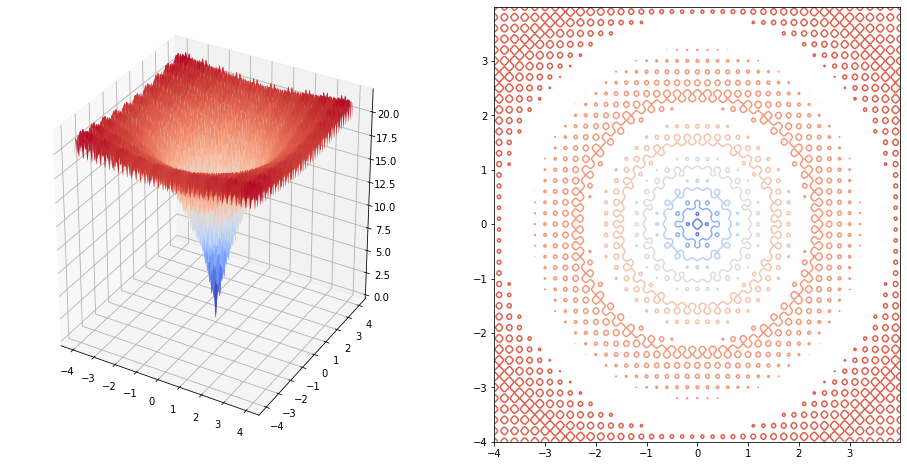

In [3]:
func_to_generate = "ackley"
ackley = optimizationFunctionFactory.create(func_to_generate) 
box_surface_2d_tourch( [-4,-4], [4,4], [0.01, 0.01], ackley )

Also, adding a couple of zooms to better see, how the funciton looks like close to its absolute minimum and far from it. 

Observe how, when we are far, there is a lot of seemly equal local minimums, such that we can get stuck in any of them with the traditional gradient descent. This is one of the motivations for adding noise to the gradient evolution.  

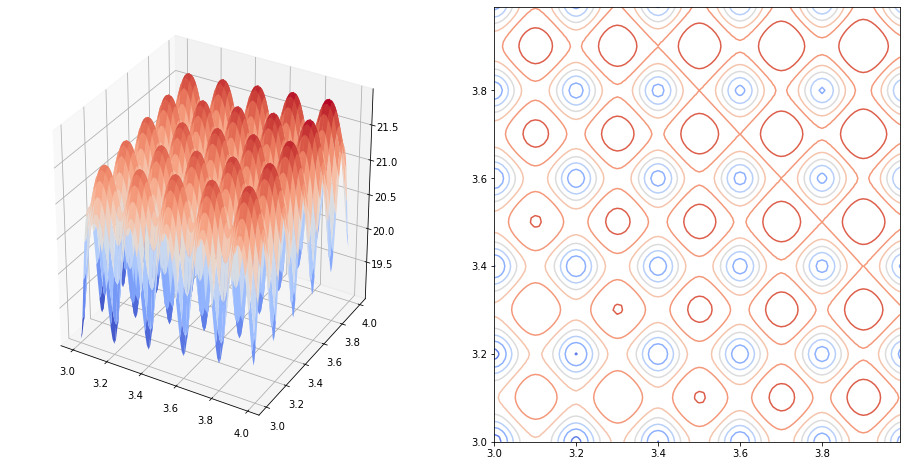

In [4]:
box_surface_2d_tourch( [3,3], [4,4], [0.01, 0.01], ackley )

When we are closer to the minimum the rugged surface does have a tendency towards the minimum. Here is where the noisy method can get the most advantage.

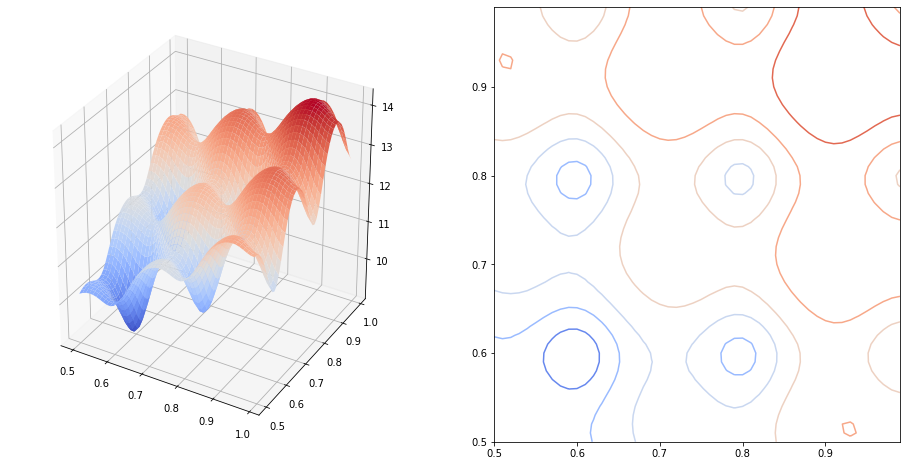

In [5]:
box_surface_2d_tourch( [0.5,0.5], [1,1], [0.01, 0.01], ackley )

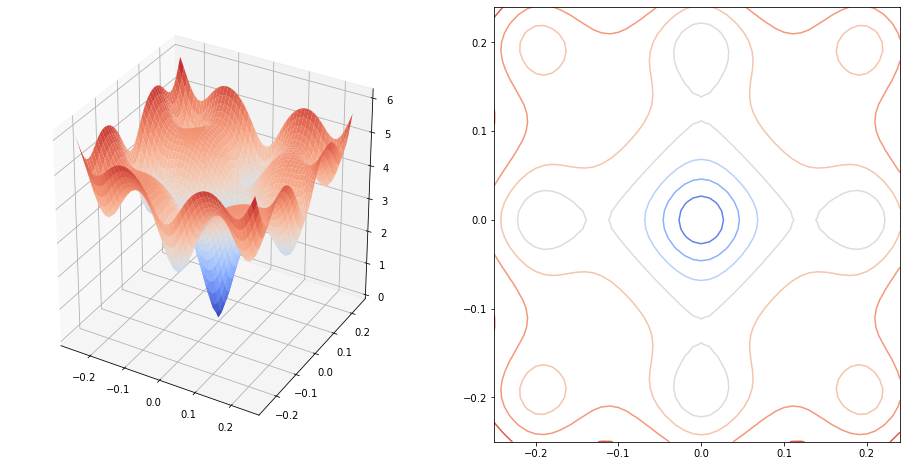

In [6]:
box_surface_2d_tourch( [-0.25,-0.25], [0.25,0.25], [0.01, 0.01], ackley )

## Analysis of the Algorithms

We will do analysis for the different algorithms when starting in a far away point. To be specific, we have set our infrastructure to pick a uniformly random point unifrom on the square $\mathcal{S}_{far} = [3.9,4.0]\times[3.9,4.0]$. For all the algorithms we choose the same random point in order to have a fair comparison. The choice for this set is driven mainly from the exploratory analysis done before. An are far from the origin, seems to be were a lot of similar local minima are, making it hard for the algorithms to find the global minima. 

### Gradient Descent

The starting point of our analysis will be the standard gradient descent. In this case, if $U:\mathbb{R}^d \mapsto \mathbb{R}$ is the funciton to be optimized, then the steps taken by the algorithm are $$x_{t+1} = x_t - \eta \nabla U(x_t),\quad t \geq 1, $$
with initial condition $x_0$. The number $\eta >0$ is known as the learning rate, and will be left constant through the evolution of the optimizer. In this and all the optimizers, we will set $\eta = 1$. Also, we will run the simulation for 1000 steps.

Let us first, create a general optimization object in the line below with all the fixed execution parameters. 

In [7]:
eta = 0.01
epochs = 1
steps = 1000

In [8]:
gopt = optimizationMethods(ackley)

Now, we are going to run the gradient descent method with the verbose flag on and the model set to IMPROVEMENTS. With these options the program will print whenever a new minumum has been reached. Recall that the seed is set by default for fairness of comparison. 

In [9]:
torch.manual_seed(0)
res = gopt.gradient_descent( eta, epochs, steps)

epoch  0 iteration  0 , x  [3.9496257305145264, 3.9768221378326416] , y  20.894397735595703
epoch  0 iteration  6 , x  [4.235530376434326, 4.189486503601074] , y  20.423383712768555
epoch  0 iteration  16 , x  [4.17361307144165, 3.787287712097168] , y  20.124345779418945
epoch  0 iteration  33 , x  [5.3972673416137695, 4.196927070617676] , y  19.852296829223633


As we can observe from the log, it seems that the gradient descent is being pushed out of the closest point, mostly because the discrete effect induced by the learning rate. Observe how, the evolution is mostly noisy on the first epoch, without achieving any real improvement. 

In [10]:
def flatten_points(res):
    x, y, z = [], [], []
    for i, v in res.values[0].items():
        x.append( v[0][0] )
        y.append( v[0][1] )
        z.append( i )
    return x, y, z

def extra_plotter(x, y, steps, marker = "go", markersize = 2, labeled = True):
    def f():        
        plt.plot(x,y,"go", markersize=4)
        if labeled:
            for i,label in enumerate(steps):
                plt.annotate(str(label), # this is the text
                             (x[i],y[i]), # this is the point to label
                             textcoords="offset points", # how to position the text
                             xytext=(0,5), # distance from text to points (x,y)
                             ha='right') 
            
    return f

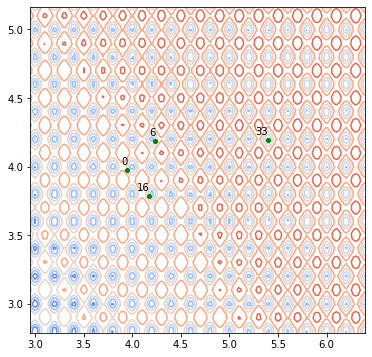

In [11]:
def plot_evolution(res):
    x,y,step_num = flatten_points(res)
    x_min, x_max = min(x)-1,max(x)+ 1
    y_min, y_max = min(y)-1,max(y)+ 1
    delta_x, delta_y = ( y_max - y_min )*0.01, ( x_max - x_min )*0.01

    box_surface_2d_tourch( [x_min, y_min], [x_max, y_max], [delta_x, delta_y], ackley, 
                          figsize= (6,6), 
                          type_of_plot = typeOfPlot.Contour, 
                          extra_plotter = extra_plotter(x,y,step_num) )
    
plot_evolution(res)

### Stochastic Gradient Descent

As we saw before, the standard gradient descent is not able (as expected) to escape the local minima of the funciton. One approach to improve the convergence is to add noise to the evolution, with the hope that the noise will push you to a random location of the space, so that the exploration of the process is larger, and hence it can achieve a better minuma. 

The steps taken by the algorithm are $$x_{t+1} = x_t - \eta \left( \nabla U(x_t) + \sigma \xi_t \right),\quad t \geq 1, $$
with initial condition $x_0$. By assumption, the numbers $(\xi_i)_i$ are IID with standard normal distribution. We now repeat the analysis done for the gradient descent algorithm to this scheme. We keep the same initial condition, and we set $\sigma = 1$, in order to have cleaner control of the variance induced by the random perturbation. 

epoch  0 iteration  0 , x  [3.9496257305145264, 3.9768221378326416] , y  20.894397735595703
epoch  0 iteration  4 , x  [4.1577959060668945, 4.195200443267822] , y  20.560558319091797
epoch  0 iteration  6 , x  [4.201467037200928, 4.024468898773193] , y  20.030914306640625
epoch  0 iteration  34 , x  [4.614125728607178, 3.3944358825683594] , y  19.799880981445312
epoch  0 iteration  45 , x  [4.006065368652344, 3.1886279582977295] , y  19.572818756103516
epoch  0 iteration  92 , x  [3.395134449005127, 2.9938302040100098] , y  19.226377487182617
epoch  0 iteration  122 , x  [2.79502010345459, 3.0040981769561768] , y  18.928829193115234
epoch  0 iteration  132 , x  [2.408449411392212, 3.0128109455108643] , y  18.844043731689453
epoch  0 iteration  151 , x  [1.8077093362808228, 3.2193686962127686] , y  18.79974937438965
epoch  0 iteration  169 , x  [2.0247995853424072, 2.4171979427337646] , y  18.375530242919922
epoch  0 iteration  170 , x  [1.7737300395965576, 2.2368555068969727] , y  18.3

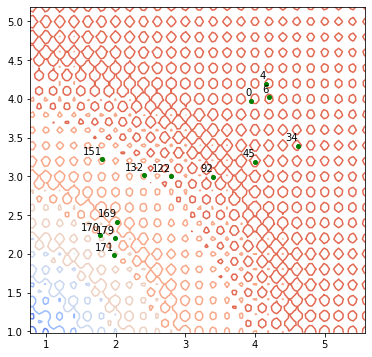

In [12]:
torch.manual_seed(0)
res_stoch = gopt.perturbed_gradient_descent( eta, epochs, steps, 1)
plot_evolution(res_stoch)

The performance as expected is considerably better. The randomness pushes the evolution to more favorable regions on the plane. 

### Our proposal: History Dependent Gradient Descent. 

Our proposal to tackle this kind of issues is to keep the effect of the noise, but also attenuate the effect of the gradient in cases where there is no hope to achieve improvement. For concreteness, we propose the following dynamics:
$$x_{t+1} = x_t - \eta  \left( e^{ -\gamma \left( U(x_t) - \min_{s\leq t } U(x_s) \right)} \nabla U(x_t) + \sigma \xi_t \right),\quad t \geq 1, $$
with initial condition $x_0$, and an hyper-parameter $\gamma > 0$. As before, we assume the numbers $(\xi_i)_i$ are IID with standard normal distribution. The analysis is repeated as with the other cases: initial condition is preserved and $\sigma = 1$. We ilustrate two cases.

#### The almost purely nose case
When $\gamma>0$ is large, the attenuation of the gradient is large, so the behavior should be about the same as the one for the perturbed gradient. We see in the evolution below that this is the case:

epoch  0 iteration  0 , x  [3.9496257305145264, 3.9768221378326416] , y  20.894397735595703
epoch  0 iteration  5 , x  [4.18633508682251, 4.164526462554932] , y  20.446937561035156
epoch  0 iteration  8 , x  [4.393406391143799, 4.386145114898682] , y  19.90333366394043
epoch  0 iteration  41 , x  [4.391455173492432, 4.603451251983643] , y  19.833608627319336
epoch  0 iteration  103 , x  [3.3992178440093994, 5.005887508392334] , y  19.746261596679688
epoch  0 iteration  217 , x  [3.0097343921661377, 4.5879387855529785] , y  19.74184226989746
epoch  0 iteration  222 , x  [2.805285930633545, 4.804681777954102] , y  19.641910552978516


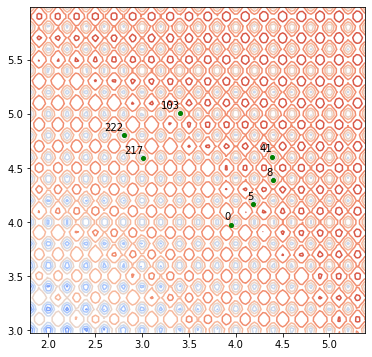

In [14]:
torch.manual_seed(0)
res_mine = gopt.modified_gradient_descent( eta, epochs, steps, 1, 1)
plot_evolution(res_mine)

#### The small $\gamma$ case
When $\gamma>0$ is small, the attenuation of the gradient and the noise compete with each other. There is an equilibrium where the performance improves considerably. We show one such cases below; we also ilustrate the case in which extremely small gamma achieves no improvement over the perturbed case. 

epoch  0 iteration  0 , x  [3.9496257305145264, 3.9768221378326416] , y  20.894397735595703
epoch  0 iteration  4 , x  [4.157750606536865, 4.195127964019775] , y  20.562135696411133
epoch  0 iteration  6 , x  [4.202702045440674, 4.023370742797852] , y  20.006011962890625
epoch  0 iteration  8 , x  [4.407942771911621, 3.9909462928771973] , y  19.796472549438477
epoch  0 iteration  163 , x  [4.600104331970215, 3.596306800842285] , y  19.687095642089844
epoch  0 iteration  400 , x  [5.192537307739258, 1.2056076526641846] , y  19.596256256103516
epoch  0 iteration  412 , x  [4.41775369644165, 0.612007737159729] , y  19.431507110595703
epoch  0 iteration  415 , x  [4.183138370513916, 0.4124661982059479] , y  19.25059700012207
epoch  0 iteration  477 , x  [4.191379547119141, 1.186350703239441] , y  19.248212814331055
epoch  0 iteration  521 , x  [2.8221845626831055, 1.6488394737243652] , y  19.241207122802734
epoch  0 iteration  522 , x  [2.648303270339966, 1.406554102897644] , y  18.6430816

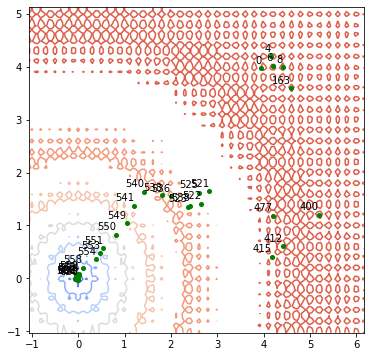

In [14]:
torch.manual_seed(0)
res_mine = gopt.modified_gradient_descent( eta, epochs, steps, 1, eta*eta)
plot_evolution(res_mine)

epoch  0 iteration  0 , x  [3.9496257305145264, 3.9768221378326416] , y  20.894397735595703
epoch  0 iteration  4 , x  [4.1577959060668945, 4.195200443267822] , y  20.560558319091797
epoch  0 iteration  6 , x  [4.201467037200928, 4.024468898773193] , y  20.030914306640625
epoch  0 iteration  34 , x  [4.614125728607178, 3.3944358825683594] , y  19.799880981445312
epoch  0 iteration  45 , x  [4.006065368652344, 3.1886279582977295] , y  19.572818756103516
epoch  0 iteration  92 , x  [3.395134449005127, 2.9938302040100098] , y  19.226377487182617
epoch  0 iteration  122 , x  [2.79502010345459, 3.0040981769561768] , y  18.928829193115234
epoch  0 iteration  132 , x  [2.408449411392212, 3.0128109455108643] , y  18.844043731689453
epoch  0 iteration  151 , x  [1.8077093362808228, 3.2193686962127686] , y  18.79974937438965
epoch  0 iteration  169 , x  [2.0247995853424072, 2.4171979427337646] , y  18.375530242919922
epoch  0 iteration  170 , x  [1.7737300395965576, 2.2368555068969727] , y  18.3

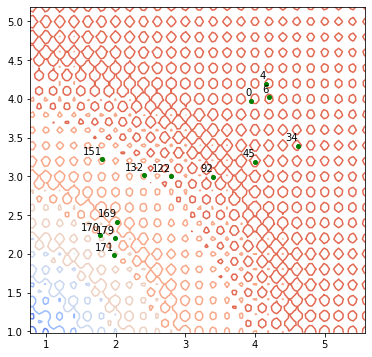

In [171]:
torch.manual_seed(0)
res_mine = gopt.modified_gradient_descent( eta, epochs, steps, 1, 1e-15)
plot_evolution(res_mine)